Пусть у нас имеется некоторый набор данных sales.csv о продажах квартир.  
— цена продажи (SalePrice, зависимая переменная),  
— наземная жилая зона (GrLivArea),  
— общее качество (Overall Quality),  
— территория гаража (GarageArea),  
— условия сделки (SaleCondition).  
1. Реализуйте построение модели линейной регрессии на этих данных.   
2. Проверьте качество модели на обучающей и тестовой выборках с помощью MAE, MSE.

In [4]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import io

In [116]:
# загрузим датасет
dataset_filename = './sales.csv'
df = pd.read_csv(dataset_filename)
df.head(5)

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition
0,208500,1710,548,7,Pave,Normal
1,181500,1262,460,6,Pave,Normal
2,223500,1786,608,7,Pave,Normal
3,140000,1717,642,7,Pave,Abnorml
4,250000,2198,836,8,Pave,Normal


In [117]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
info_filename = f'./{Path(dataset_filename).stem}_info.xlsx'
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
columns = s.splitlines()[3].split()
lines =   [line.split() for line in s.splitlines()[5:-2]]
lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
# lines
# columns[1:]
# df_info = pd.DataFrame(lines,columns=columns[1:])
# df_info['nu'] = df.nunique().values
# df.nunique().n
# df_info.join(df.nunique(), on='Column')
# df.nunique().to_frame(name='Columns').reset_index()
# pd.concat([pd.DataFrame(lines,columns=columns[1:]), df.nunique()], axis=1, ignore_index=True)# .set_index(['#']).reset_index()
df_info = pd.merge(
    pd.DataFrame(lines, columns=columns[1:])
    , df.nunique().to_frame(name='Nu'), 
    left_on='Column', 
    right_index=True)# .set_index(['#']).reset_index()
df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
df_info = pd.merge(df_info, df_vc, how='left', on='Column')
df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
if not Path(info_filename).exists():
    df_info.to_excel(info_filename)
df_info


,Column,Non-Null,Count,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,SalePrice,1460,non-null,int64,663,NaN,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0
1,GrLivArea,1460,non-null,int64,861,NaN,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
2,GarageArea,1460,non-null,int64,441,NaN,1460.0,472.980137,213.804841,0.0,334.5,480.0,576.00,1418.0
3,OverallQual,1460,non-null,int64,10,"[(1, 2), (2, 3), (3, 20), (4, 116), (5, 397), ...",1460.0,6.099315,1.382997,1.0,5.0,6.0,7.00,10.0
4,Street,1460,non-null,object,2,"[(Grvl, 6), (Pave, 1454)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,SaleCondition,1460,non-null,object,6,"[(Abnorml, 101), (AdjLand, 4), (Alloca, 12), (...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
# Датасет содержит 1460 значений, не имеет пропусков.
# Датасет содержит два числовых признака (не считая целевой переменной) и три категориальных признака.
# Категориальный признак OverallQual имеет числовой формат и естественную порядковую связь - не требует преобразования.
# Категориальные признаки Street SaleCondition имеют строковый формат и требуют преобразования в числовой формат.
target_feature = 'SalePrice'
numbers_features = ['GrLivArea', 'GarageArea']
cat_features = ['OverallQual', 'Street', 'SaleCondition']

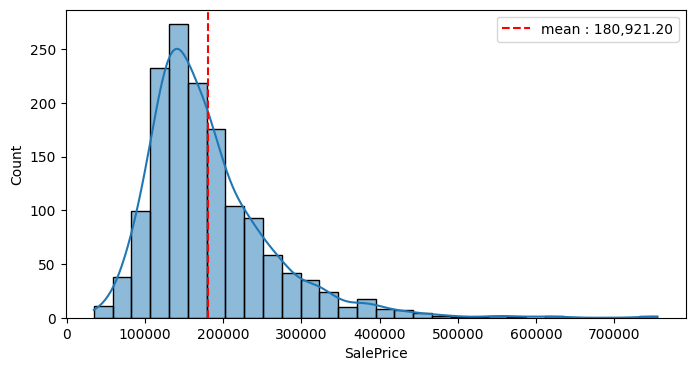

In [119]:
# Визуализируем целевую переменную
target_feature_mean = df[target_feature].mean()
plt.figure(figsize=(8, 4))
g = sns.histplot(data=df, bins=30, x=target_feature, kde=True)
g.axvline(target_feature_mean, color='red', ls='--', label=f"mean : {target_feature_mean:,.2f}")
plt.legend();
# Наблюдаем ассимментичное распределение целевой переменной с "хвостом" вправо. Пока не понятно являются ли эти значения выбросами.


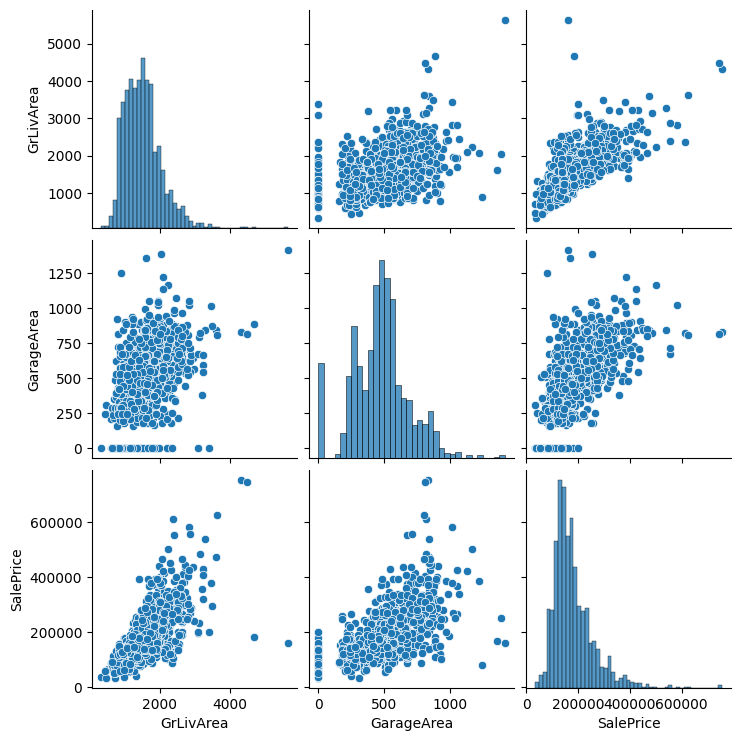

In [120]:
sns.pairplot(df[numbers_features + [target_feature]]);

In [121]:
# Наблюдаем нестандартные объекты по цене менее 200 т. с большой площадью, при этом качество объектов самое высокое. Что не соответствует общему тренду
# Отобразим их
df.loc[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 200_000)]
# Таких объектов всего 2. В учебных целях, предположим, что это аномалии и удалим их из датасета
# Наблюдаем объекты с нулевой площадью гаража, целесообразно было бы построить отдельные модели с гаражом и без.

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition
523,184750,4676,884,10,Pave,Partial
1298,160000,5642,1418,10,Pave,Partial


In [122]:
df = df.loc[(df['GrLivArea'] < 4000) | (df['SalePrice'] > 200_000)]
df.shape


(1458, 6)

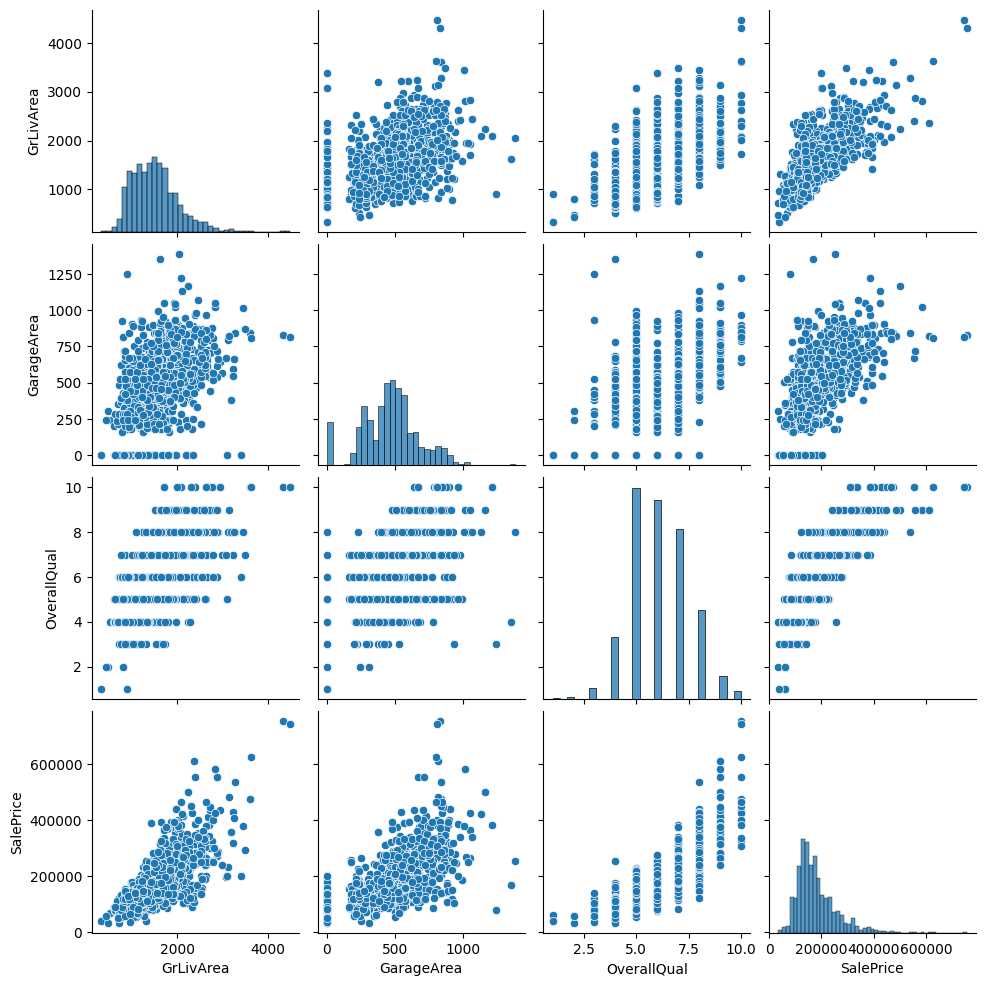

In [123]:
# Отобразим скорректированный датасет и добавим категориальную переменную
sns.pairplot(df[numbers_features + ['OverallQual'] + [target_feature]]);
# Наблюдаем явную коррреляцию целевой переменной с признаками GrLivArea, OverallQual
# Так же наблюдаем корреляцию признаков GrLivArea, OverallQual между собой.  

<AxesSubplot: xlabel='OverallQual', ylabel='SalePrice'>

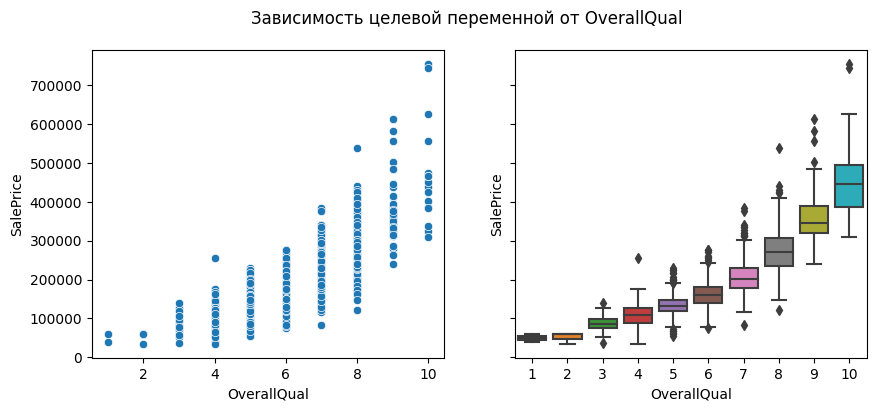

In [124]:
# Визуализируем категориальную пременную OverallQual
# Наблюдаем, что значение признака коррелирует с целевой переменной.
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True) #
fig.suptitle('Зависимость целевой переменной от OverallQual')
sns.scatterplot(ax=axs[0], data=df, x='OverallQual', y='SalePrice')
sns.boxplot(ax=axs[1], data=df, x='OverallQual', y='SalePrice')

<AxesSubplot: xlabel='Street', ylabel='SalePrice'>

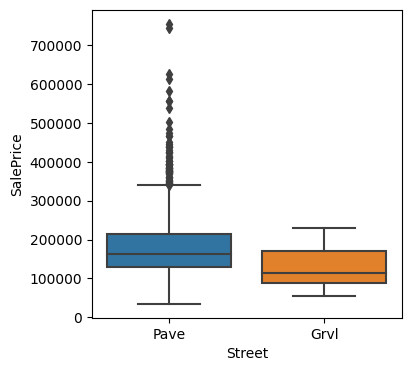

In [125]:
# Визуализируем признак Street
# Наблюдаем, что само по себе значение признака не коррелирует с целевой переменной.
plt.figure(figsize=(4, 4))
sns.boxplot(df, x='Street', y='SalePrice')

<AxesSubplot: xlabel='SaleCondition', ylabel='SalePrice'>

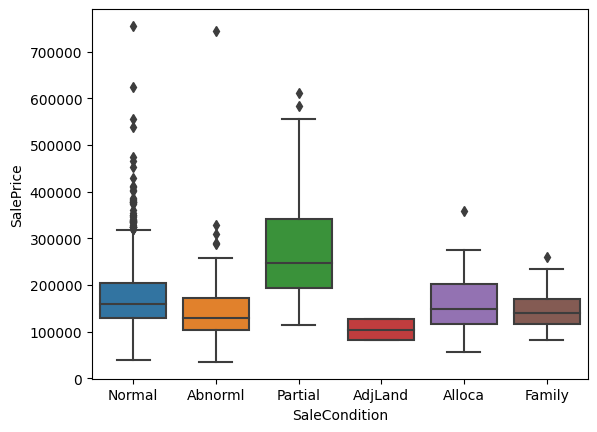

In [126]:
# Визуализируем признак SaleCondition
# Наблюдаем, что само по себе значение признака не коррелирует с целевой переменной.plt.figure(figsize=(6, 4))
sns.boxplot(df, x='SaleCondition', y='SalePrice')

In [128]:
# Закодируем признак Street
df['Street_bin'] = df['Street'].map({'Grvl':0, 'Pave':1})
df['Street_bin'].value_counts()

1    1452
0       6
Name: Street_bin, dtype: int64

In [132]:
# Закодируем признак SaleCondition с использованием ONE-HOT Encoder
# Значения признака не имеют явной порядковой связи
# Набор значений не большой и конечный
from sklearn.preprocessing import OneHotEncoder

In [140]:
ohe_features = cat_features[2:]

['SaleCondition']

In [173]:
ohe_features = cat_features[2:]
oh_encoder = OneHotEncoder(sparse_output = False)
oh_encoder.fit(df[ohe_features])
columns=oh_encoder.get_feature_names_out()
if len(set(columns).intersection(df.columns)) > 0:
    df.drop(columns=columns, inplace=True)
df = df.reset_index(drop=True).join(pd.DataFrame(oh_encoder.transform(df[ohe_features]), columns=columns)) #.drop(columns=ohe_features[1:])
df

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition,Street_bin,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500,1710,548,7,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0
1,181500,1262,460,6,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0
2,223500,1786,608,7,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0
3,140000,1717,642,7,Pave,Abnorml,1,1.0,0.0,0.0,0.0,0.0,0.0
4,250000,2198,836,8,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,175000,1647,460,6,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0
1454,210000,2073,500,6,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0
1455,266500,2340,252,7,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0
1456,142125,1078,240,5,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0


In [195]:
# Для модели линейной регрессии целесообразно провести стандартизацию признаков
from sklearn.preprocessing import StandardScaler

In [203]:
scale_features = numbers_features + ['OverallQual']
scale_features_new = [('_').join([col, 'scaled']) for col in scale_features]
scaler = StandardScaler().fit(df[scale_features])
df_scale = df.join(pd.DataFrame(scaler.transform(df[scale_features].copy()), columns=scale_features_new))
df_scale

,SalePrice,GrLivArea,GarageArea,OverallQual,Street,SaleCondition,Street_bin,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,GrLivArea_scaled,GarageArea_scaled,OverallQual_scaled
0,208500,1710,548,7,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,0.393013,0.357973,0.658506
1,181500,1262,460,6,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,-0.489391,-0.056795,-0.068293
2,223500,1786,608,7,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,0.542706,0.640770,0.658506
3,140000,1717,642,7,Pave,Abnorml,1,1.0,0.0,0.0,0.0,0.0,0.0,0.406800,0.801022,0.658506
4,250000,2198,836,8,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,1.354202,1.715398,1.385305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,175000,1647,460,6,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,0.268925,-0.056795,-0.068293
1454,210000,2073,500,6,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,1.107996,0.131736,-0.068293
1455,266500,2340,252,7,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,1.633893,-1.037158,0.658506
1456,142125,1078,240,5,Pave,Normal,1,0.0,0.0,0.0,0.0,1.0,0.0,-0.851806,-1.093717,-0.795092


In [208]:
# Разобъем выборку на тестовую и обучающую
X = df_scale.drop(columns=['Street', 'SaleCondition'] + [target_feature] + scale_features).copy()
y = df_scale[target_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=df['OverallQual'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1166, 10) (292, 10) (1166,) (292,)


In [209]:
X

,Street_bin,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,GrLivArea_scaled,GarageArea_scaled,OverallQual_scaled
0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.393013,0.357973,0.658506
1,1,0.0,0.0,0.0,0.0,1.0,0.0,-0.489391,-0.056795,-0.068293
2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.542706,0.640770,0.658506
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.406800,0.801022,0.658506
4,1,0.0,0.0,0.0,0.0,1.0,0.0,1.354202,1.715398,1.385305
...,...,...,...,...,...,...,...,...,...,...
1453,1,0.0,0.0,0.0,0.0,1.0,0.0,0.268925,-0.056795,-0.068293
1454,1,0.0,0.0,0.0,0.0,1.0,0.0,1.107996,0.131736,-0.068293
1455,1,0.0,0.0,0.0,0.0,1.0,0.0,1.633893,-1.037158,0.658506
1456,1,0.0,0.0,0.0,0.0,1.0,0.0,-0.851806,-1.093717,-0.795092


1. Реализуйте построение модели линейной регрессии на этих данных.

In [210]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


2. Проверьте качество модели на обучающей и тестовой выборках с помощью MAE, MSE.

In [215]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Метрики тренировочноый выборки MAE: {mae_train:,.0f}, MSE: {mse_train:,.0f}')
print(f'Метрики тестовой выборки MAE: {mae_test:,.0f}, MSE: {mse_test:,.0f}')

Метрики тренировочноый выборки MAE: 26,455, MSE: 1,382,992,504
Метрики тестовой выборки MAE: 25,597, MSE: 1,387,128,989


In [ ]:
# Странная история, метрика MAE на тренировочной больше, чем на тестовой, а метрика MSE набоборот, хотя ожидается, что отклонения будут однонаправленные

In [217]:
# на тесте больше смещение
print(y_train.mean()-y_pred_train.mean())
print(y_test.mean()-y_pred_test.mean())

-0.20368782163131982
-664.2311643835565


C:\Users\Alex\AppData\Local\Temp\ipykernel_22368\2073385648.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
C:\Users\Alex\AppData\Local\Temp\ipykernel_22368\2073385648.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45);


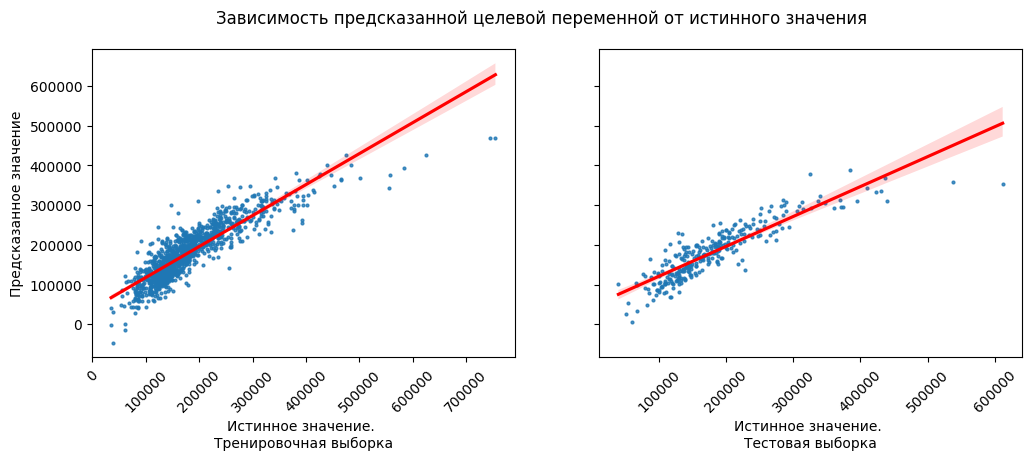

In [251]:
# Отобразим значение предсказанной переменной от истинного значения целевой переменной
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True) #
fig.suptitle('Зависимость предсказанной целевой переменной от истинного значения')
sns.regplot(ax=axs[0], x=y_train, y=y_pred_train, scatter_kws={'s':4}, line_kws={'color':'red'})
axs[0].set_xlabel('Истинное значение. \nТренировочная выборка')
axs[0].set_ylabel('Предсказанное значение')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
sns.regplot(ax=axs[1], x=y_test, y=y_pred_test, scatter_kws={'s':4}, line_kws={'color':'red'} )
axs[1].set_xlabel('Истинное значение. \nТестовая выборка')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45);
# Наблюдаем ситуацию, что зависимость предсказанного значения и истинного значения нелинейная.
# При росте значения целевой переменной дисперсия возрастает.
# На больших и маленьких значениях величина ошибки возрастает.
# Скорее всего это связано с тем, что в датасете значений с крайними значениями целевой переменной меньше чем со значениями,
# расположенными ближе к медианному значению. Что мы и наблюдали на графике распределения целевой переменной.
